<h1 style='text-align:center;font-weight:bold;color:blue'>Spam Message Detection</h1>

## <b>1 Introduction</b>
### <b>1.1 Background</b>
Developing an efficient spam message filtering system to automatically classify incoming messages as spam or not spam is crucial for enhancing user experience and safeguarding against malicious content. The system needs to accurately distinguish between legitimate messages and unsolicited or harmful ones to ensure users only receive relevant and safe communications. This project aims to build a classification model to flag a spam message.

- <b>Type I Error (False Positive)</b>: This occurs when a real email is incorrectly marked as spam. The cost associated with this error is typically higher because it can result in missing important communications, which could have significant repercussions, such as lost business opportunities or critical information not being received. Therefore, a higher cost of USD5 per misclassified non-spam email might be assigned to reflect its potential impact.
- <b>Type II Error (False Negative)</b>: This happens when a spam email is mistakenly identified as non-spam and ends up in the inbox. While this is also undesirable, the consequence is usually less severe than a Type I error. It might lead to some inconvenience and time wasted in manually deleting the spam emails, but it’s less likely to result in a significant loss. Hence, a lower cost of USD1 per misclassified spam email could be justified.

As the difference between losses caused by the type I and type II error is relatively small, this project will use F1 as the metric for evaluating the machine learning model's performance. The F1 score provides a balanced consideration between precision and recall. Precision is usually used when we want to optimize reducing type I error while recall can be adopted when the goal is to minimize the financial loss due to type II error. The F1 ensures the model achieves a good trade-off between two types of errors.

### <b>1.2 Dataset</b>
The dataset used to build the classification model was obtained form [Kaggle](https://www.kaggle.com/datasets/uciml/sms-spam-collection-dataset/data). This dataset contains two columns: `status` (target) and `text` (feature).
- `status`: The status of the message (`ham` or `spam`)
- `text`: The message content

## <b>2 Data Preparation</b>

In [404]:
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as ImbPipeline  
from sklearn.feature_extraction.text import TfidfVectorizer
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.model_selection import GridSearchCV, cross_validate, StratifiedKFold
from sklearn.metrics import accuracy_score, recall_score, precision_score, roc_auc_score, f1_score, classification_report
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.model_selection import KFold
import lime
import lime.lime_text
from lime.lime_text import LimeTextExplainer

In [405]:
# import data
data = pd.read_csv("data/spam.csv")

# display snipet of data
print(f"The dataset contains {data.shape[0]} rows and {data.shape[1]} columns.")
data.head()

The dataset contains 5572 rows and 2 columns.


,status,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


<b>Comment</b>: 
- The data consists of two columns (`status` and `text`) and 5,572 rows.
- Before moving further, it is necessary to understand the proportion of the message status (spam vs ham) as an uneven distribution in the target variable can affect the classification model.

In [406]:
# get propotion of status
target_col = pd.DataFrame({'count':data['status'].value_counts(),
                           'proportion':round(data['status'].value_counts(normalize=True) *100, 2)})
display(target_col)

,count,proportion
ham,4825,86.59
spam,747,13.41


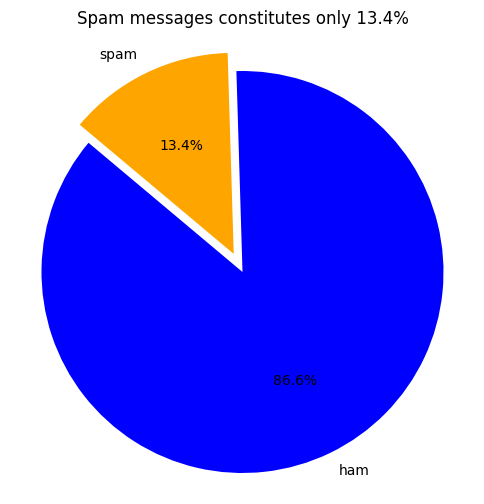

In [407]:
# display pie chart
labels = target_col.index
sizes = target_col['count']
colors = ['blue', 'orange']
explode = (0, 0.1) 

plt.figure(figsize=(6, 6))
plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=False, startangle=140)
# set equal aspect ratio to draw a circle
plt.axis('equal')  
plt.title('Spam messages constitutes only 13.4%')
plt.show()


<b>Comment</b>: 
- As the proportion between spam and ham is not even (13.4 vs 86.6), the imbalanced distribution should be done during the modeling process to avoid bias in the model and impact on the model's evaluation.
- The model can be biased towards the majority class so it may not perform well when predicting the minority class, resulting in high false negatives (type II errors).
- When the categories in the target variable are imbalanced, evaluation metrics may not be accurate as they cannot refkect the effectiveness of the model in detecting minority class.
- For this reasons, an experiment on different resampling techniques may be advantageous for dealing with the imbalance issue.

In [408]:
# check missing values
(data.isna().sum() * 100).reset_index().rename(columns={'index':'column', 0: 'count'})

,column,count
0,status,0
1,text,0


**Comment**: As there are no missing values in the dataset, a further data analysis (e.g., to find the mechanism of missingness) and missing data treatment (e.g., data imputation or record removal) will be necessary.

In [409]:
# build class for cleaning text
class TextCleaner(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        if isinstance(X, list):
            # handle the case where X is a list of texts
            return [self.clean_text(text) for text in X]
        elif isinstance(X, pd.Series):
            # handle the case where X is a series
            return X.apply(self.clean_text)
        elif isinstance(X, str):
            # handle the case where X is a single string
            return self.clean_text(X)
        else:
            raise ValueError("Unsupported input!")

    def clean_text(self, text):
        # convert text input to lowercase
        text = text.lower()  
        # remove sequence of numbers (digits)
        text = re.sub(r'\d+', '', text)
        # remove numbers with letters (e.g., 123cd)
        text = re.sub(r'\b\d+\b', '', text)  
        # remove urls
        text = re.sub(r'http\S+|www\S+', '', text) 
        # remove non-alphabetic characters 
        text = re.sub(r'[^a-zA-Z\s]', '', text)  
        # remove excessive white spaces
        text = re.sub(r'\s+', ' ', text).strip()  
        return text


**Comment**: 
- The custom transformer cleans raw text in the dataset into cleaner one. 
- First, the raw text will be converted into lowercase. Converting text into lowercase is beneficial to regularize them into the same lettercase. This is necessary because capital letters in English are only used mostly in the first letter in a sentence and proper nouns. 
- Second, numbers (`\d+`) will be removed (replaced them using nothing `''`) by using regular expression pattern. As TF-IDF will score word-types (vocabulary) based on their frequencies, different numbers will pose a challenge for the ML model. For example, if in a message contains two numbers, let's say 200 and 8, these numbers will be two different columns along with their frequencies.
- Third, URL removal is performed. URL is removed to reduce noise and focus more on textual content. Incorporating URLs in the analysis will be less efficient as there will be a different column assigned for every unique URL.
- Fourth, punctuation marks will be discarded from the text. These elements do not contribute much to the textual content.
- Last, extra-spaces are also deleted. 
- The effect of the text cleaning will be shown later.

In [410]:
# check the dataset
data.iloc[1:10, ]

,status,text
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
5,spam,FreeMsg Hey there darling it's been 3 week's n...
6,ham,Even my brother is not like to speak with me. ...
7,ham,As per your request 'Melle Melle (Oru Minnamin...
8,spam,WINNER!! As a valued network customer you have...
9,spam,Had your mobile 11 months or more? U R entitle...


**Comment**: As the target variable, namely `status`, is in the form of strings, and machine learning algorithms can take numeric representations only, the categories will be converted into `1` (spam) and `0` (ham). 

In [411]:
# specify features and target 
X = data['text']
y = data['status'].apply(lambda x: 1 if x == 'spam' else 0)

# split dataset into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"The feature consists of {X_train.shape[0]} rows or {round(X_train.shape[0]/len(data)*100, 2)}% of the total data.")
print(f"The feature consists of {X_test.shape[0]} rows or {round(X_test.shape[0]/len(data)*100, 2)}% of the total data.")
print('y_train distribution:')
display(y_train.value_counts(normalize=True).reset_index())
print('y_test distribution:',)
display(y_test.value_counts(normalize=True).reset_index())

The feature consists of 4457 rows or 79.99% of the total data.
The feature consists of 1115 rows or 20.01% of the total data.
y_train distribution:


,index,status
0,0,0.866053
1,1,0.133947


y_test distribution:


,index,status
0,0,0.865471
1,1,0.134529


**Comment**
- 80% of the data will be used as the training set and the rest is used as the test set.
- After this data splitting process, pipelines will be setup for the data modeling phase.

In [412]:
# pipeline 1: logistic regression
logistic_regression = ImbPipeline([
    ('cleaner', TextCleaner()),
    ('tfidf', TfidfVectorizer()),
    ('smote', SMOTE(random_state=42)),
    ('model', LogisticRegression(max_iter=2000)) 
])

# pipeline 2: naive bayes
naive_bayes = ImbPipeline([
    ('cleaner', TextCleaner()),
    ('tfidf', TfidfVectorizer()),
    ('smote', SMOTE(random_state=42)),
    ('model', MultinomialNB())  
])

# pipeline 3: svm
svm = ImbPipeline([
    ('cleaner', TextCleaner()),
    ('tfidf', TfidfVectorizer()),
    ('smote', SMOTE(random_state=42)),
    ('model', SVC())  
])

# pipeline 4: random forest
random_forest = ImbPipeline([
    ('cleaner', TextCleaner()),
    ('tfidf', TfidfVectorizer()),
    ('smote', SMOTE(random_state=42)),
    ('model', RandomForestClassifier())
])

# pipeline 5: gradient boosting
gbm = ImbPipeline([
    ('cleaner', TextCleaner()),
    ('tfidf', TfidfVectorizer()),
    ('smote', SMOTE(random_state=42)),
    ('model', GradientBoostingClassifier())  
])

# collect all pipelines, incl the algorithms
models = {
    'Logistic Regression': logistic_regression,
    'Naive Bayes': naive_bayes,
    'SVM': svm,
    'Random Forest': random_forest,
    'Gradient Boosting': gbm
}

**Comment**
- Model 1 is build using a logistic regression algorithm. This model exploits pipeline from the data cleaning as described above, feature extraction using `TfidfVectorizer` to convert individual words to TF-IDF scores. In other words, the vocabularies in the emails will be represented in the form of TF-IDF scores (see below for the brief explanation on TF-IDF). After the representation, the result will be passed on to the logistic algorithm.
- Model 2 to Model 5 are also similar to the Model 1 in the sense that they also use the same text cleaning class and the same feature extraction technique. The main difference lies on the use of different algorithms, namely Naive Bayes, Support Vector Machine, Random Forest, and Gradient Boosting.
- These all pipelines are stored in a dictionary which will be used for data modeling in the next phase. 

**Special note on Naive Bayes**
- Naive Bayes algorithm uses here is the multinomial version (Multinomial Naive Bayes). The Multinomial NB is more considered than, for example, Bernoulli Naive Bayes as Multinomial Naive Bayes are more suitable for data containing frequencies of occurrences (e.g., raw frequencies or TF-IDF scores) whereas Bernoulli Naive Bayes is more appropriate when the data is in the form of absence or presence of a vocabulary in documents.

### **Brief Explanation on TF-IDF**
Term frequency-inverse document frequency (TF-IDF) a text representation based on the frequency of a word. But it does not only consider the occurrence of the word in a document but also the commonality of the word across documents. By considering both how often a word appears and how common or rare it is across document, TF-IDF helps underscores the importance of the word.

To calculate TF-IDF score, the following formula can be used $$\text{TF-IDF}(t,d)=\text{TF}(t,d)\times \text{IDF}(t)$$
- TF: Frequency of term $t$ in document
- IDF: $$\text{IDF} = \log \left (\frac{\text{total documents}}{\text{number of documents with term}\: t}  \right )+ 1$$

In [413]:
# display tf-idf vectorization output
pipeline = Pipeline([
    ('cleaner', TextCleaner()),
    ('tfidf', TfidfVectorizer())
])

# fit and transform the data using the pipeline
tfidf_matrix = pipeline.fit_transform(X)

# get feature names (for col names)
feature_names = pipeline.named_steps['tfidf'].get_feature_names_out()

# convert the tf-idf matrix to df
tfidf_df = pd.DataFrame(data=tfidf_matrix.toarray(), columns=feature_names)

# display result
display(tfidf_df.head())

,aa,aah,aaooooright,aathilove,aathiwhere,ab,abbey,abdomen,abeg,aberdeen,...,zeros,zf,zhong,zindgi,zoe,zogtorius,zoom,zouk,zs,zyada
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


**Comment**
- The `TextCleaner` class cleans the text from unnecessary elements mentioned earlier. Those text elements are considered not relevant as TF-IDF focuses more on keywords of spam and not-spam messages.
- The `TfidfVectorizer` computes TF-IDF scores at once in the background so no step-by-step process for calculating TF score, IDF score, then TF-IDF is provided.

## <b>3 Data Modeling</b>

Before executing the data modeling, I will recap the metrics for evaluating the classification model's performance. As previously mentioned in the introduction section, the chosen metric is F1. In general, F1 combines two other performance metrics, namely precision and recall.
- **Precision**: This metrics evaluates accuracy of a model at identifying positive cases, and in this case, what is meant by "positive case" is a spam. 
$$\text{Precision} = \frac{TP}{TP + FP}$$
- **Recall**: This metrics measures the rate of true positives (e.g., actual spam, predicted as spam) from actual positive instances.
$$\text{Recall} = \frac{TP}{TP + FN}$$ 
- As F1 is a combination between precision and recall, the F1 score can be measured as follows. 
$$F1=\frac{2 \times \text{precision} \times \text{recall}}{\text{precision} + \text{recall}}$$

**Note**: Despite the metric of interest is F1, other metrics such as accuracy and area under the ROC curve (ROC AUC) score will also be shown to complement the main metric.

In [414]:
dfs = []
# set up cross-val fold with 5 splits
cv = KFold(n_splits=5, shuffle=True, random_state=42)  

for name, model in models.items():
    # initialize lists to store metrics
    accuracy_list, recall_list, f1_list, precision_list, auc_list = [], [], [], [], []
    
    for train_index, test_index in cv.split(X):
        # split data into train and test sets for this fold
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        # fit the model
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
    
        accuracy = accuracy_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1score = f1_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        auc = roc_auc_score(y_test, y_pred)

        # append metrics for this fold
        accuracy_list.append(accuracy)
        recall_list.append(recall)
        f1_list.append(f1score)
        precision_list.append(precision)
        auc_list.append(auc)

    # calculate and store average metrics
    avg_accuracy = round(np.mean(accuracy_list), 4)
    avg_recall = round(np.mean(recall_list), 4)
    avg_f1score = round(np.mean(f1_list), 4)
    avg_precision = round(np.mean(precision_list), 4)
    avg_auc = round(np.mean(auc_list), 4)

    # create df for each model's metrics (averaged across folds)
    df = pd.DataFrame({
        'Model': [name],
        'Accuracy': [avg_accuracy],
        'Recall': [avg_recall],
        'Precision': [avg_precision],
        'AUC': [avg_auc],
        'F1 Score': [avg_f1score],
    })
    
    # append dfs
    dfs.append(df)

# display results
metrics_df = pd.concat(dfs, ignore_index=True)
display(metrics_df.sort_values(by='F1 Score', ascending=False))

,Model,Accuracy,Recall,Precision,AUC,F1 Score
2,SVM,0.9799,0.8665,0.9823,0.9320,0.9206
0,Logistic Regression,0.9770,0.9037,0.9243,0.9461,0.9134
3,Random Forest,0.9745,0.8127,0.9968,0.9061,0.8952
1,Naive Bayes,0.9693,0.9356,0.8502,0.9551,0.8908
4,Gradient Boosting,0.9627,0.8168,0.8972,0.9011,0.8543


**Comment** 
- The table of modeling outputs summarizes performance reports on different models based on five metrics, namely accuracy, recall, precision, AUC (Area under the Curve), and F1. 
- Based on the table, the highest performing model is Support Vector Machine (SVM) with F1 score of 0.9206.
- While this model outperforms other models, it is necessary to find a better performing model by using hyperparameter tuning on these all models.

In [415]:
# set up parameter grids
param_grids = {
    'Logistic Regression': {
        'model__C': [0.01, 0.1, 1, 10, 100],
        'model__solver': ['liblinear', 'saga']
    },
    'Naive Bayes': {
        'model__alpha': [0.01, 0.1, 1, 10]
    },
    'SVM': {
        'model__C': [0.01, 0.1, 1, 10, 100],
        'model__kernel': ['linear', 'rbf', 'poly']
    },
    'Random Forest': {
        'model__n_estimators': [10, 50, 100],
        'model__max_depth': [None, 10, 20, 30]
    },
    'Gradient Boosting': {
        'model__n_estimators': [50, 100, 200],
        'model__learning_rate': [0.01, 0.1, 0.2]
    }
}

**Comment**
- [Logistic regression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html#sklearn.linear_model.LogisticRegression): `model__C` controls the strength of the regularization with values ranging from 0.01 to 100. The idea is the larger the value, the more prevention of overfitting is done. The grid search will look for the best value based on the defined range on the logistic regression model. Furthermore, `model__solver` specifies optimization algorithms, namely liblinear and saga, for the logistic regression model.
- [Multinomial Naive Bayes](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html#sklearn.naive_bayes.MultinomialNB): The `model__alpha` is a smoothing param for the NB model with values between 0.01 and 10. The grid searches the most optimal smoothing effect based on this range.
- [Support Vector Machine](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html#sklearn.svm.SVC): `model__C` also controls the regularization strength in this model while `model__kernel` specifies kernel functions (radial basis function and polynomial) of SVM model.
- [Random Forest](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html#randomforestclassifier): The `model__n_estimators` specifies the number of decision trees to include in the RF, and `model__max_depth` controls the max depth each tree in the RF.
- [Gradient Boosting](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html#gradientboostingclassifier): `model__n_estimators` defines the num of trees and the `model__learning_rate` controls the step size for updating the modeel weights.

In [416]:
# perform hyperparameter tuning 
dfs = []
for name, model in models.items():
    grid_search = GridSearchCV(model, param_grids[name], cv=5, scoring='f1', n_jobs=-1)
    grid_search.fit(X_train, y_train)
    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test)
    
    # add eval metrics 
    accuracy = accuracy_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred)
    f1score = f1_score(y_test, y_pred)
    
    # store eval metrics in df
    df = pd.DataFrame({
        'Model': [name],
        'Best Params': [grid_search.best_params_],
        'Accuracy': [round(accuracy, 4)],
        'Recall': [round(recall, 4)],
        'Precision': [round(precision, 4)],
        'AUC': [round(auc,4)],
        'F1 Score': [round(f1score, 4)]
    })
    
    # append dfs
    dfs.append(df)

# display results
metrics_df = pd.concat(dfs, ignore_index=True)
display(metrics_df.sort_values(by='F1 Score', ascending=False))

,Model,Best Params,Accuracy,Recall,Precision,AUC,F1 Score
0,Logistic Regression,"{'model__C': 10, 'model__solver': 'liblinear'}",0.9811,0.8981,0.9658,0.9464,0.9307
2,SVM,"{'model__C': 1, 'model__kernel': 'linear'}",0.9803,0.9045,0.9530,0.9486,0.9281
1,Naive Bayes,{'model__alpha': 0.1},0.9749,0.9299,0.8957,0.9561,0.9125
3,Random Forest,"{'model__max_depth': None, 'model__n_estimator...",0.9713,0.7962,1.0000,0.8981,0.8865
4,Gradient Boosting,"{'model__learning_rate': 0.2, 'model__n_estima...",0.9686,0.8217,0.9485,0.9072,0.8805


**Comment**
- The table displays the results of model tuning using grid search cross-validation (grid search CV). This technique seeks to find the optimal hyperparameters based on defined values for each model and uses cross-validation to assess the performance of each combination.
- As shown, Logistic Regression has the highest F1 score of 0.9307, offering the highest balance between precision and recall. 
- As a result, LR will be chosen and its performance will be further evaluated graphically using different plots.

## **4 Best Model and the Evaluation**

### **4.1 Model Selection: Linear Regression**

In [417]:
# store naive bayes as model (for simplification)
model = logistic_regression

# specify cv technique
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# perform cross-validation and store results
accuracy_scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='accuracy')
recall_scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='recall')
precision_scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='precision')
auc_scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='roc_auc')
f1_scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='f1')

# create df to store results for each fold
results_df = pd.DataFrame({
    'Fold': np.arange(1, 11),
    'Accuracy': accuracy_scores,
    'Recall': recall_scores,
    'Precision': precision_scores,
    'AUC': auc_scores,
    'F1 Score': f1_scores
})

# get mean and std
mean_scores = results_df.mean()
std_scores = results_df.std()

# combine into one df
mean_df = pd.DataFrame({
    'Fold': ['Mean'],
    'Accuracy': [mean_scores['Accuracy']],
    'Recall': [mean_scores['Recall']],
    'Precision': [mean_scores['Precision']],
    'AUC': [mean_scores['AUC']],
    'F1 Score': [mean_scores['F1 Score']]
})

std_df = pd.DataFrame({
    'Fold': ['Std'],
    'Accuracy': [std_scores['Accuracy']],
    'Recall': [std_scores['Recall']],
    'Precision': [std_scores['Precision']],
    'AUC': [std_scores['AUC']],
    'F1 Score': [std_scores['F1 Score']]
})

results_df = pd.concat([results_df, mean_df, std_df], ignore_index=True)

# display results
display(results_df)

,Fold,Accuracy,Recall,Precision,AUC,F1 Score
0,1,0.979821,0.915254,0.931034,0.996015,0.923077
1,2,0.982063,0.915254,0.947368,0.992817,0.931034
2,3,0.966368,0.847458,0.892857,0.994088,0.869565
3,4,0.979821,0.881356,0.962963,0.980423,0.920354
4,5,0.991031,0.966102,0.966102,0.999255,0.966102
5,6,0.975336,0.881356,0.928571,0.983401,0.904348
6,7,0.977578,0.915254,0.915254,0.978102,0.915254
7,8,0.991031,0.932203,1.000000,0.997898,0.964912
8,9,0.961798,0.830508,0.875000,0.979582,0.852174
9,10,0.964045,0.847458,0.877193,0.983007,0.862069


In [418]:
# specify param grid
param_grid = {
    'model__C': [0.01, 0.1, 1, 10, 100],
    'model__solver': ['liblinear', 'saga']
}

# specify cv technique
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# perform grid search cv with cross-validation
grid_search = GridSearchCV(estimator=model, 
                           param_grid=param_grid, 
                           scoring='f1', 
                           cv=cv, 
                           n_jobs=-1)
grid_search.fit(X_train, y_train)

# get the best model
best_model = grid_search.best_estimator_

# init lists to store results for each fold
accuracy_scores = []
recall_scores = []
precision_scores = []
roc_auc_scores = []
f1_scores = []

# perform cross-validation and collect scores for each fold
for fold, (train_idx, val_idx) in enumerate(cv.split(X_train, y_train), 1):
    X_train_fold, X_val_fold = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_train_fold, y_val_fold = y_train.iloc[train_idx], y_train.iloc[val_idx]

    # fit the model on the training fold
    best_model.fit(X_train_fold, y_train_fold)
    
    # predict on the validation fold
    y_pred = best_model.predict(X_val_fold)
    
    # calculate evaluation metrics for the fold
    accuracy = accuracy_score(y_val_fold, y_pred)
    recall = recall_score(y_val_fold, y_pred)
    precision = precision_score(y_val_fold, y_pred)
    roc_auc = roc_auc_score(y_val_fold, y_pred)
    f1 = f1_score(y_val_fold, y_pred)
    
    # combine scores
    accuracy_scores.append(accuracy)
    recall_scores.append(recall)
    precision_scores.append(precision)
    roc_auc_scores.append(roc_auc)
    f1_scores.append(f1)

# get mean and SD of each metric
mean_accuracy = np.mean(accuracy_scores)
mean_recall = np.mean(recall_scores)
mean_precision = np.mean(precision_scores)
mean_roc_auc = np.mean(roc_auc_scores)
mean_f1 = np.mean(f1_scores)

std_accuracy = np.std(accuracy_scores)
std_recall = np.std(recall_scores)
std_precision = np.std(precision_scores)
std_roc_auc = np.std(roc_auc_scores)
std_f1 = np.std(f1_scores)

# create df to display results
results_dict = {
    'Fold': list(range(1, 11)) + ['Mean', 'Std'],
    'Accuracy': accuracy_scores + [mean_accuracy, std_accuracy],
    'Recall': recall_scores + [mean_recall, std_recall],
    'Precision': precision_scores + [mean_precision, std_precision],
    'AUC': roc_auc_scores + [mean_roc_auc, std_roc_auc],
    'F1 Score': f1_scores + [mean_f1, std_f1]
}
results_df = pd.DataFrame(results_dict)

# display result
display(results_df)

,Fold,Accuracy,Recall,Precision,AUC,F1 Score
0,1,0.986547,0.932203,0.964912,0.963518,0.948276
1,2,0.979821,0.915254,0.931034,0.952459,0.923077
2,3,0.984305,0.932203,0.948276,0.962226,0.940171
3,4,0.984305,0.915254,0.964286,0.955043,0.939130
4,5,0.982063,0.932203,0.932203,0.960934,0.932203
5,6,0.975336,0.881356,0.928571,0.935510,0.904348
6,7,0.982063,0.915254,0.947368,0.953751,0.931034
7,8,0.986547,0.915254,0.981818,0.956335,0.947368
8,9,0.975281,0.847458,0.961538,0.921138,0.900901
9,10,0.982022,0.864407,1.000000,0.932203,0.927273


**Comment**: 
- The hyperparameter tuning process involving 10 splits results in mean F1 score of 0.92 $\pm$ 0.01 (SD). 
- For more details how this logistic regression model performs in distinguishing spam from non-spam messages, let us see the following evaluation metrics, including those for each class (class 0 and class 1).

In [419]:
# print best model
print(best_model)

Pipeline(steps=[('cleaner', TextCleaner()), ('tfidf', TfidfVectorizer()),
                ('smote', SMOTE(random_state=42)),
                ('model',
                 LogisticRegression(C=100, max_iter=2000, solver='liblinear'))])


**Comment**: Data will firstly go through the text cleaning process using `TextCleaner`, and be converted into TF-IDF scoring via `TfidfVectorizer`. After its completion, the data will be resampled using synthetic minority over-sampling (`SMOTE`) technique to balance the target class (`spam` vs `ham`). And in the end, the preprocessed data will be fed to the logistic regression algorithm. The algoritm is the linear model used for the binary classification tasks with several parameters as obtained from the hyperparam tuning earlier.
- `C=100` is the regularization param
- `max_iter=2000` is the max number of iterations 
- `solver=liblinear` is the algorithm for the optimization.

### **4.2 Best Model Evaluation**

In this section unseen or testing data will be tested on the best model to see how well it can perform. Using the testing data is considered to see how the model's learning is generalizable to the unseen data. Evaluating on testing data therefore provides a more realistic assessment of the model's performance. On the other hand, a learning curve will be an exception for the evaluation. It is because a learning curve is designed to evaluate the model's performance as the training data size increases.

#### **4.2.1 Classification Report**

In [421]:
# train the model
best_model.fit(X_train, y_train)

# make predictions on the test set
y_pred = best_model.predict(X_test)
y_pred_proba = best_model.predict_proba(X_test)[:, 1]

# evaluate the model
accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1score = f1_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)
report = classification_report(y_test, y_pred)

# display result
print('Here are the evaluation metrics:')
print('Accuracy:', round(accuracy, 4))
print('Recall:', round(recall, 4))
print('F1 score:', round(f1score, 4))
print('Precision:', round(precision, 4))
print('ROC-AUC:', round(roc_auc, 4))
print('\nClassification Report:')
print(report)

Here are the evaluation metrics:
Accuracy: 0.9803
Recall: 0.8917
F1 score: 0.9272
Precision: 0.9655
ROC-AUC: 0.9898

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.99      0.99       957
           1       0.97      0.89      0.93       157

    accuracy                           0.98      1114
   macro avg       0.97      0.94      0.96      1114
weighted avg       0.98      0.98      0.98      1114



**Comment**
- The model shows strong performance in general with high precision, recall, and F1 for both classes (class 0 and class 1).
- The F1 score (the main metric in this project) along with the precision score is also high for both classes, indicating the model makes very few misclassifications. 
- Class 0 (ham/not spam) is predicted with slightly higher precision and reecall compared to class 1 (spam).

#### **4.2.2 Precision Recall Curve**

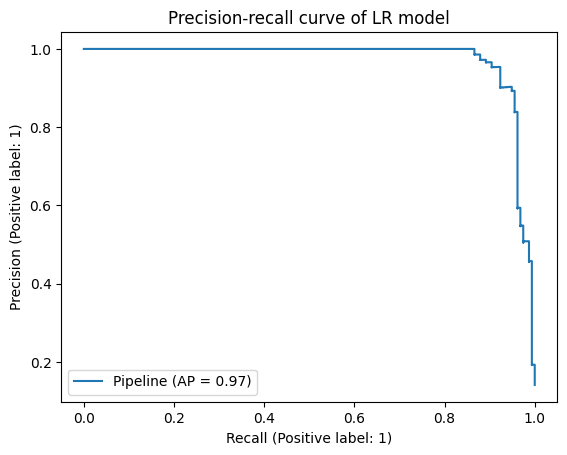

In [426]:
from sklearn.metrics import PrecisionRecallDisplay
PrecisionRecallDisplay.from_estimator(
   best_model, X_test, y_test)
plt.title('Precision-recall curve of LR model', loc='center')
plt.show()

**Comment**
- Precision-recall curve displays the precision-recall trade-off of a model in different thresholds.
- The model starts with high accuracy (almost 1.0) but begins to make more mistakes when it tries to capture all positive cases. 
- The high average precision (AP) score indicates that despite this trade-off, the model is generally reliable in distinguishing between classes.

#### **4.2.3 Learning Curve**

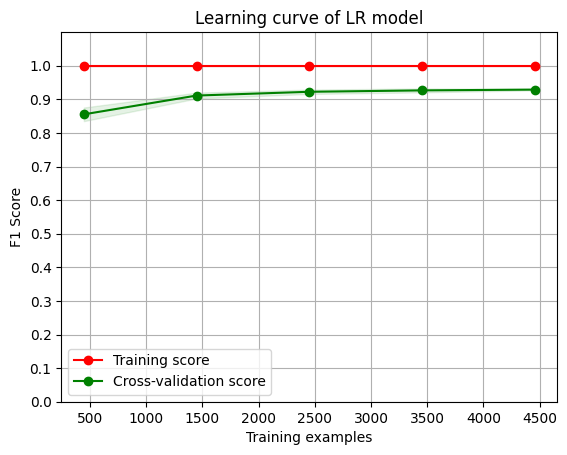

In [434]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve
from sklearn.metrics import f1_score

train_sizes, train_scores, test_scores = learning_curve(
    best_model, X, y, train_sizes=np.linspace(0.1, 1.0, 5), scoring='f1', cv=5
)

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.figure()
plt.title("Learning curve of LR model")
plt.xlabel("Training examples")
plt.ylabel("F1 Score")
plt.grid()

plt.fill_between(
    train_sizes,
    train_scores_mean - train_scores_std,
    train_scores_mean + train_scores_std,
    alpha=0.1,
    color="r",
)
plt.fill_between(
    train_sizes,
    test_scores_mean - test_scores_std,
    test_scores_mean + test_scores_std,
    alpha=0.1,
    color="g",
)
plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
plt.legend(loc="best")
plt.ylim(0.0, 1.1)  
plt.yticks(np.arange(0, 1.1, 0.1))
plt.show()

**Comment**
- The training score (red line) represents the performance of the best model (logistic regression) on the training data. The training score remains high from the start to the end regardless of how many training samples were added.
- The cross-balidation score (green line) shows how well the model performs on unseen data. Despite starting low, the score is getting higher as the number of training instance was added. The score got more stable after 1100 instances.
- As the both lines are stable and close to each other, adding more training data does not likely to increase the performance of the model.

#### **4.2.4 ROC-AUC Curve**

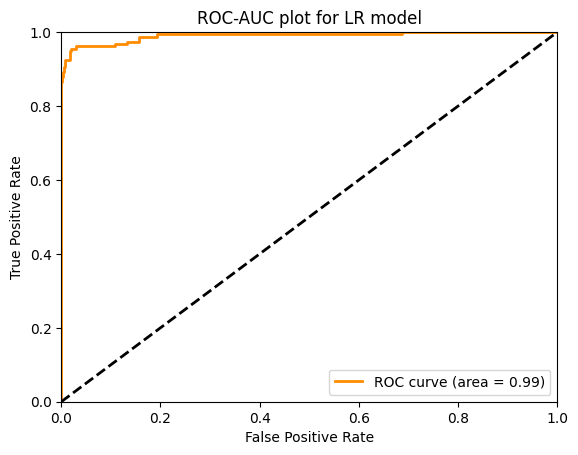

In [424]:
from sklearn.metrics import roc_curve, auc

# Get the best model
best_model = grid_search.best_estimator_

# Predict probabilities
y_pred_proba = best_model.predict_proba(X_test)

# Compute ROC curve and ROC area for each class
fpr, tpr, _ = roc_curve(y_test, y_pred_proba[:, 1])
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2,
         label='ROC curve (area = {0:0.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-AUC plot for LR model')
plt.legend(loc="lower right")
plt.xlim(0.0, 1.0)
plt.ylim(0.0, 1.0)
plt.show()

**Comment** (GANTI)
- The ROC-AUC plot displays a high true positive rate (TPR) with a low false positive rate (FPR), suggesting that the model correctly identifies a high number of positives while keeping false positives (FPs) low.
- As the closer the AUC score to 1.0, the better performance a model is, the plot then indicates model is performing very well in terms of ROC-AUC, which is a strong indicator of its ability to classify messages accurately as "Spam" or "Ham".

#### **4.2.5 Reliability Curve**

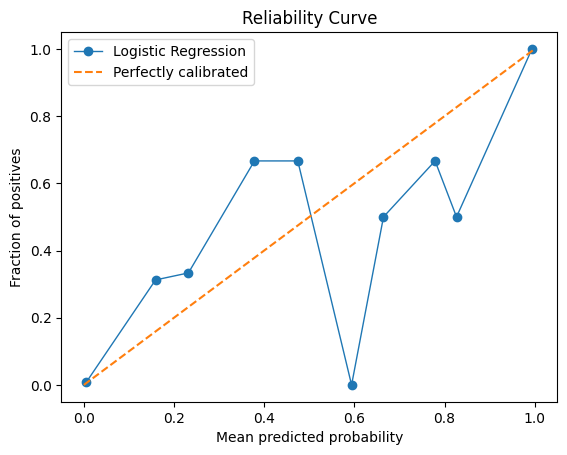

In [442]:
from sklearn.calibration import CalibratedClassifierCV, calibration_curve

prob_pos = best_model.predict_proba(X_test)[:, 1]
prob_true, prob_pred = calibration_curve(y_test, prob_pos, n_bins=10)
plt.plot(prob_pred, prob_true, marker='o', linewidth=1, label='Logistic Regression')
plt.plot([0, 1], [0, 1], linestyle='--', label='Perfectly calibrated')
plt.xlabel('Mean predicted probability')
plt.ylabel('Fraction of positives')
plt.title('Reliability Curve')
plt.legend()
plt.show()

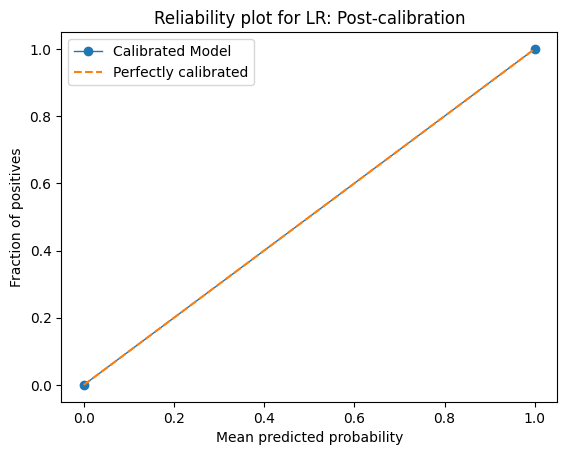

In [443]:
# calibrate model
calibrated_best_model= CalibratedClassifierCV(best_model, method='isotonic', cv='prefit')
calibrated_best_model.fit(X_train, y_train)

# generate new predicted probabilities
y_prob_calibrated = calibrated_best_model.predict_proba(X_train)[:, 1]
prob_true_calibrated, prob_pred_calibrated = calibration_curve(y_train, y_prob_calibrated, n_bins=10)

# plot reliability curve
plt.plot(prob_pred_calibrated, prob_true_calibrated, marker='o', linewidth=1, label='Calibrated Model')
plt.plot([0, 1], [0, 1], linestyle='--', label='Perfectly calibrated')
plt.xlabel('Mean predicted probability')
plt.ylabel('Fraction of positives')
plt.title('Reliability plot for LR: Post-calibration')
plt.legend()
plt.show()

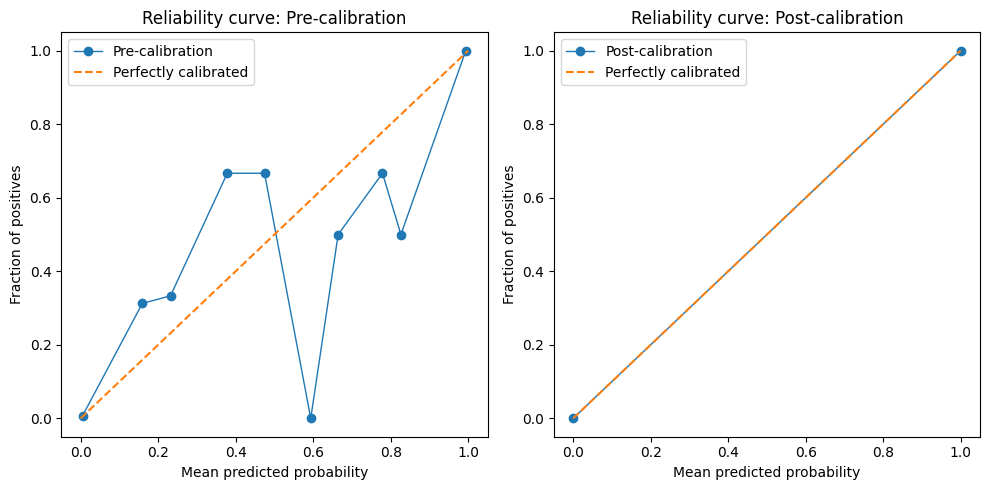

In [439]:
import matplotlib.pyplot as plt
from sklearn.calibration import CalibratedClassifierCV, calibration_curve

# generate prediction and probability of prediction
y_pred_best_model = best_model.predict(X_test)
y_prob_best_model = best_model.predict_proba(X_test)[:, 1]

# make calibration curve plots
prob_true, prob_pred = calibration_curve(y_test, y_prob_best_model, n_bins=10)
calibrated_best_model = CalibratedClassifierCV(best_model, method='isotonic', cv='prefit')
calibrated_best_model.fit(X_train, y_train)
y_prob_calibrated = calibrated_best_model.predict_proba(X_train)[:, 1]
prob_true_calibrated, prob_pred_calibrated = calibration_curve(y_train, y_prob_calibrated, n_bins=10)

# combine plots using subplot with nrows=1, ncols=2
plt.figure(figsize=(10, 5))  

# plot pre-calibration curve
plt.subplot(1, 2, 1)  
plt.plot(prob_pred, prob_true, marker='o', linewidth=1, label='Pre-calibration')
plt.plot([0, 1], [0, 1], linestyle='--', label='Perfectly calibrated')
plt.xlabel('Mean predicted probability')
plt.ylabel('Fraction of positives')
plt.title('Reliability curve: Pre-calibration')
plt.legend()

# plot post-calibration curve
plt.subplot(1, 2, 2)  
plt.plot(prob_pred_calibrated, prob_true_calibrated, marker='o', linewidth=1, label='Post-calibration')
plt.plot([0, 1], [0, 1], linestyle='--', label='Perfectly calibrated')
plt.xlabel('Mean predicted probability')
plt.ylabel('Fraction of positives')
plt.title('Reliability curve: Post-calibration')
plt.legend()

plt.tight_layout()  
plt.show()

**Comment**
- Before calibrating the model (plot on the left), the model's predictions may not be aligned well with the actual outcome. This misalignment can be seen in the reliability curve on the left where the blue line deviates from the diagonal line. This misalignment might indicate the model's overconfidence in some predictions while underconfidence in others (there are ups and downs around the diagonal line). For this reason, a calibration on the best model is required.
- The calibration is done by using isotonic method, instead of sigmoid one, as the patterns (reliability curve on the left) are complex. The isotonic calibration can adapt to sharp changes, e.g., in mean predicted probability of 0.6.
- After the calibration, the model's predictions are more closely aligned with the actual outcomes as the curve show that the predicted probabilities (blue line) follow the diagonal line more closely. In general, this indicates that the calibrated version provides probabilities which are more representative of the actual outcomes.

#### **4.2.6 Confusion Matrix and Cost Simulation**

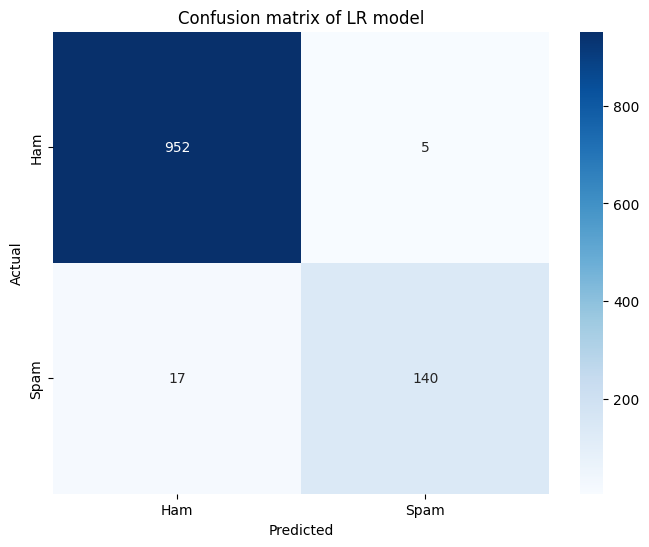

In [427]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# calculate confusion matrix
conf_mat = confusion_matrix(y_test, y_pred_best_model)

# create confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Ham', 'Spam'], 
            yticklabels=['Ham', 'Spam'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion matrix of LR model')
plt.show()

**Comment**
- **True Positives (TP)** (actual Ham, prediction Ham): 925 "Ham" messages were correctly identified as "Ham".
- **False Negatives (FN)** (actual Spam, prediction Ham): 17 "Spam" messages were incorrectly labeled as "Ham".
- **False Positives (FP)** (actual Ham prediction Spam): There were 4 instances where "Ham" messages were wrongly marked as "Spam".
- **True Negatives (TN)** (actual Spam, prediction Spam): 140 spam messages were correctly classified as "Spam".

In [473]:
# check model's errors
eval = pd.DataFrame({'text':X_test,
                     'actual':y_test,
                     'predicted':y_pred_best_model,
                     'prob': y_prob_best_model
                     })
# create function to highlight status
def highlight_fn_fp(s):
  color_map = {'FN': 'yellow', 'FP': 'lightblue'}
  return ['background-color: {}'.format(color_map.get(v)) for v in s]

different_predictions = eval[eval['actual'] != eval['predicted']]
different_predictions['status'] = (np.where((different_predictions['actual'] == 1) & 
                                            (different_predictions['predicted'] == 0), 
                                            'FN', 'FP'))
num_different_predictions = len(different_predictions)
num_FN = len(different_predictions[different_predictions['status'] == 'FN'])
num_FP = len(different_predictions[different_predictions['status'] == 'FP'])

# display output
print(f"Number of errors: {num_different_predictions}.")
print(f"Number of False Negatives (FN): {num_FN}.")
print(f"Number of False Positives (FP): {num_FP}.")
display(different_predictions.sort_values(by='status').style.apply(highlight_fn_fp, subset=['status']))

Number of errors: 22.
Number of False Negatives (FN): 17.
Number of False Positives (FP): 5.


,text,actual,predicted,prob,status
190,Are you unique enough? Find out from 30th August. www.areyouunique.co.uk,1,0,0.139465,FN
5035,You won't believe it but it's true. It's Incredible Txts! Reply G now to learn truly amazing things that will blow your mind. From O2FWD only 18p/txt,1,0,0.008372,FN
4752,Cashbin.co.uk (Get lots of cash this weekend!) www.cashbin.co.uk Dear Welcome to the weekend We have got our biggest and best EVER cash give away!! These..,1,0,0.159623,FN
4142,"In The Simpsons Movie released in July 2007 name the band that died at the start of the film? A-Green Day, B-Blue Day, C-Red Day. (Send A, B or C)",1,0,0.010879,FN
4067,TBS/PERSOLVO. been chasing us since Sept for�38 definitely not paying now thanks to your information. We will ignore them. Kath. Manchester.,1,0,0.081424,FN
4014,You will be receiving this week's Triple Echo ringtone shortly. Enjoy it!,1,0,0.267160,FN
3572,You won't believe it but it's true. It's Incredible Txts! Reply G now to learn truly amazing things that will blow your mind. From O2FWD only 18p/txt,1,0,0.008372,FN
5370,dating:i have had two of these. Only started after i sent a text to talk sport radio last week. Any connection do you think or coincidence?,1,0,0.152695,FN
2773,How come it takes so little time for a child who is afraid of the dark to become a teenager who wants to stay out all night?,1,0,0.158987,FN
3417,LIFE has never been this much fun and great until you came in. You made it truly special for me. I won't forget you! enjoy @ one gbp/sms,1,0,0.000311,FN


In [471]:
# get descriptive statistics
different_predictions.groupby('status').agg(func={'prob':'describe'})

prob                                                              \
       count      mean       std       min       25%       50%       75%   
status                                                                     
FN      17.0  0.168318  0.167411  0.000311  0.010879  0.152695  0.267160   
FP       5.0  0.709417  0.091169  0.593829  0.673838  0.676999  0.782264   

                  
             max  
status            
FN      0.493517  
FP      0.820157

**Comment**
- Most misclassified emails are false negatives with high predicted probabilities, ranging between 0.59 and 0.82. 
- This suggests the model might be struggling with borderline cases or specific types of legitimate emails.

In [224]:
# prediction based on confusion matrix
TP = 925        
FN = 17        
FP = 4          
TN = 140       

# define cost per error (as defined in introduction)
cost_per_FP = 5
cost_per_FN = 1

# calculate total costs
total_cost_FP = FP * cost_per_FP
total_cost_FN = FN * cost_per_FN

# print the results
print(f"Total cost of false positives (FP): ${total_cost_FP}")
print(f"Total cost of false negatives (FN): ${total_cost_FN}")
print(f"Total misclassification cost: ${total_cost_FP + total_cost_FN}")

Total cost of false positives (FP): $20
Total cost of false negatives (FN): $17
Total misclassification cost: $37


In [225]:
# given values
total_messages = 1086
ham_messages = 929      # based on classif report
spam_messages = 157     # based on classif report

# define cost per error
cost_per_FP = 5
cost_per_FN = 1

# calculate total costs without the model
total_cost_without_model_FP = ham_messages * cost_per_FP
total_cost_without_model_FN = spam_messages * cost_per_FN

# calculate total misclassification cost without the model
total_cost_without_model = total_cost_without_model_FP + total_cost_without_model_FN

# print the results
print(f"Total cost of misclassifying all ham messages (FP): ${total_cost_without_model_FP}")
print(f"Total cost of misclassifying all spam messages (FN): ${total_cost_without_model_FN}")
print(f"Total misclassification cost without using the model: ${total_cost_without_model}")

Total cost of misclassifying all ham messages (FP): $4645
Total cost of misclassifying all spam messages (FN): $157
Total misclassification cost without using the model: $4802


**Comment**
- Without the model, the misclassified emails will cost \$4,802 with users constantly sifting through unwanted messages and missing important communication.
- But with the model, the misclassification costs \$37.
- The model therefore can save \$4765 (\$4802 − \$37 = \$4765), significantly enhancing productivity and reducing frustratin due to dealing with spams.

## **5 Model Explanation**

In [226]:
# make predictions on the test set
y_pred = calibrated_best_model.predict(X_test)

# get the predicted probabilities for the positive class
y_prob = calibrated_best_model.predict_proba(X_test)[:, 1]

# combine the predictions and probabilities into a df
predictions_df = pd.DataFrame({
    'Text': X_test,
    'Actual': y_test,
    'Predicted': y_pred,
    'Pred Probability': y_prob
})

# display the first few rows of the df
display(predictions_df.head(10))

,Text,Actual,Predicted,Pred Probability
3,U dun say so early hor... U c already then say...,0,0,0.000000
4,"Nah I don't think he goes to usf, he lives aro...",0,0,0.000000
5,FreeMsg Hey there darling it's been 3 week's n...,1,1,0.721124
9,Had your mobile 11 months or more? U R entitle...,1,1,1.000000
16,Oh k...i'm watching here:),0,0,0.000000
34,Thanks for your subscription to Ringtone UK yo...,1,1,1.000000
54,SMS. ac Sptv: The New Jersey Devils and the De...,1,1,0.527800
55,Do you know what Mallika Sherawat did yesterda...,0,0,0.000000
64,Ok lar i double check wif da hair dresser alre...,0,0,0.000000
66,"Today is \song dedicated day..\"" Which song wi...",0,0,0.000000


### **5.1 Test for Class 0 (Not Spam/Ham)**

In [227]:
# check text in row 88
predictions_df['Text'].iloc[88]

"Hi i won't b ard 4 christmas. But do enjoy n merry x'mas."

In [228]:
# check predicted probability for instance 88
predictions_df.iloc[88, predictions_df.columns.get_loc('Pred Probability')]

0.0

**Comment** 
- Two code blocks above are used to see instances and predicted probability of the selected email.
- As can be seen, the status is a ham and the probability of model's prediction is 0.0, meaning that the probability of the message class 1 (spam) is 0%.
- Now let us see how the model works using LIME (**L**ocal **I**nterpretable **M**odel-agnostic **E**xplanations ). 
    - This explainer helps in explaining why the model made a specific prediction by highlighting the influence of each feature. 
    - In this case, the feature is each word extracted from the email (column `text`).
- Since this is local explanation, we will take one instance from the dataset, and let LIME explains why the best model (calibrated) makes a prediction as it does.

In [229]:
# init LIME text explainer
explainer = LimeTextExplainer(class_names=['Ham', 'Spam'])

# explain instance idx 11
exp = explainer.explain_instance(predictions_df['Text'].iloc[88], calibrated_best_model.predict_proba, num_features=50)

# display the explanation
exp.show_in_notebook(text=True)

**Comment**:
- The LIME output highlights what the prediction of the model is, how big the prediction probability is, how much each feature (individual word) contributes to the prediction, and color-highlighted words according to the model's classification.
- As shown previously, the actual status of the message is a ham, and based on the LIME output, the model predicted the message as a ham with with predicted probability 0.0, meaning 0% of the message is a spam.
- The message as explain the model means "Hi, I won't be around for Christmas. But do enjoy and merry Chirstmas.", using informal texting syle.
- The output displays that the majority of words in the message is more associated with the non-spam (ham) message rather than spam.
- Furthermore, to be fair, below a test on class 1 (spam message) will also be carried out and explained using LIME.

### **5.2 Test for Class 1 (Spam)**

In [230]:
# check instance in df
predictions_df[predictions_df['Text'].str.contains('New Jersey Devil')]

,Text,Actual,Predicted,Pred Probability
54,SMS. ac Sptv: The New Jersey Devils and the De...,1,1,0.5278


In [231]:
# explain instance idx 6
exp = explainer.explain_instance(predictions_df.iloc[6, 0], calibrated_best_model.predict_proba, num_features=50)

# display the explanation
exp.show_in_notebook(text=True)

**Comment**
- As shown on the dataframe, the message is classified as a spam and predicted by the model as a spam.
- In the LIME explanation it is shown that several words, particularly "reply", "new", "ac", and "play", have the highest contributions to the message predicted as a spam.

## **6 Conclusions and Recommendations**

<h1 style='text-align:center;font-style:italic'>---End---</h1>